In [7]:
!pip install plotly
!pip install plotly-geo
!pip install geopandas --upgrade
!pip install pyshp==1.2.10
!pip install shapely==1.6.3
!pip install chart_studio
!pip install -q kaggle

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from shapely.geometry import Point
import seaborn as sns
import geopandas as gpd
from geopandas import GeoDataFrame
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

## EDA

In [9]:
df=pd.read_csv('scrubbed.csv', delimiter=',', skiprows=0, low_memory=False)

In [10]:
df.dropna(subset = ['country'], inplace=True)
df.dropna(subset = ['state'], inplace=True)
df

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611
5,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.5950000,-82.188889
7,10/10/1965 23:45,norwalk,ct,us,disk,1200,20 minutes,A bright orange color changing to reddish colo...,10/2/1999,41.1175000,-73.408333
...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444
80328,9/9/2013 22:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500
80329,9/9/2013 22:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444
80330,9/9/2013 22:20,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.9011111,-77.265556


In [11]:
df['latitude']= df['latitude'].map(lambda x: float(x)) #pasar de object a float

In [12]:
puntos = [Point(xy) for xy in zip(df['longitude '], df['latitude'])]
gdf = GeoDataFrame(df, geometry=puntos)   
gdf.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,geometry
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,POINT (-97.94111 29.88306)
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,POINT (-96.64583 28.97833)
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,POINT (-157.80361 21.41806)
5,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.595000,-82.188889,POINT (-82.18889 36.59500)
7,10/10/1965 23:45,norwalk,ct,us,disk,1200,20 minutes,A bright orange color changing to reddish colo...,10/2/1999,41.117500,-73.408333,POINT (-73.40833 41.11750)


In [13]:
#Fecha
df["datetime"] = df["datetime"].apply(lambda x: x.replace("24:00", "00:00"))
df['datetime'] = pd.to_datetime(df['datetime'])
#pasar variabvle duración a numeric
df['duration (seconds)'] = pd.to_numeric(df['duration (seconds)'],errors='coerce')
#crear año en una columba separada
df['year']=df['datetime'].dt.year

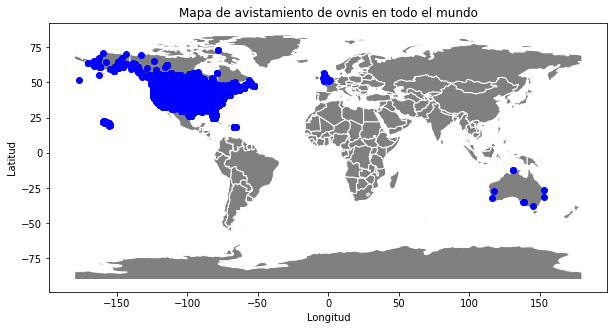

In [14]:
#Mapa con geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6),color='gray', edgecolor='white')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
gdf.plot(ax=ax, color='blue')
plt.title('Mapa de avistamiento de ovnis en todo el mundo')
plt.show()

In [15]:
numavisw = pd.DataFrame(df.groupby('country')['country'].count())
numavisw['Número'] = numavisw['country']
x = pd.Series(numavisw.index).apply(lambda x: x.upper())
numavisw.index = np.arange(0, numavisw.shape[0])
numavisw['País'] = x
numavisw.drop('country', axis=1, inplace=True)
numavisw

,Número,País
0,10,AU
1,2985,CA
2,12,GB
3,65114,US


In [16]:
data=dict(type='choropleth',
          colorscale='Tealgrn',
          z=numavisw['Número'],
          locations = ['Australia','Canada','Great Britain','USA'],
          locationmode = 'country names',
          text=numavisw['País'],
          marker=dict(line=dict(color='rgb(0,0,0)',width=1)),
          colorbar={'title': 'Número de avistamientos de Ovnis'})


In [17]:
layout=dict(title=' Avistamientos de Ovnis en el Mundo',
            geo=dict(scope='world',
                     showlakes= True,
                     lakecolor='rgb(85,173,240)')
            )

In [18]:
choromap=go.Figure(data=[data],layout=layout)

In [19]:
choromap.show()

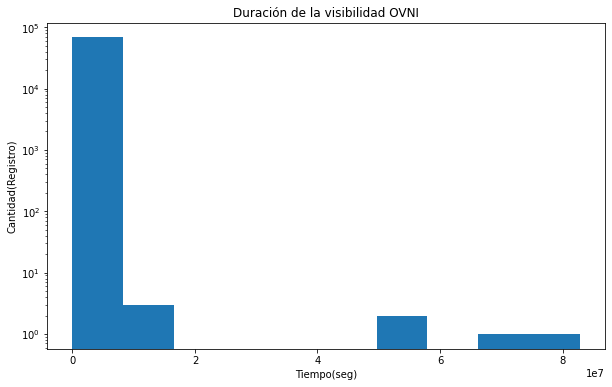

In [20]:
plt.figure(figsize=(10,6))
plt.hist(x = df['duration (seconds)'], log=True)
plt.title('Duración de la visibilidad OVNI')
plt.ylabel('Cantidad(Registro)')
plt.xlabel('Tiempo(seg)')
plt.show()

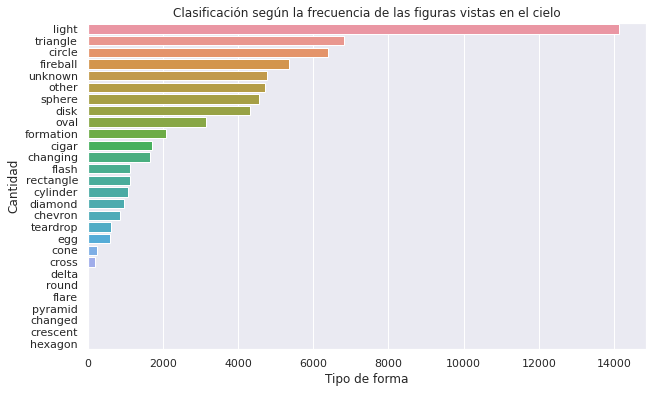

In [21]:
sns.set(style='darkgrid')
plt.figure(figsize=(10,6))
ax = sns.countplot(y='shape', data=df, \
                   order = df['shape'].value_counts().index).\
set_title('Clasificación según la frecuencia de las figuras vistas en el cielo')

plt.ylabel('Cantidad')
plt.xlabel('Tipo de forma')
plt.show()

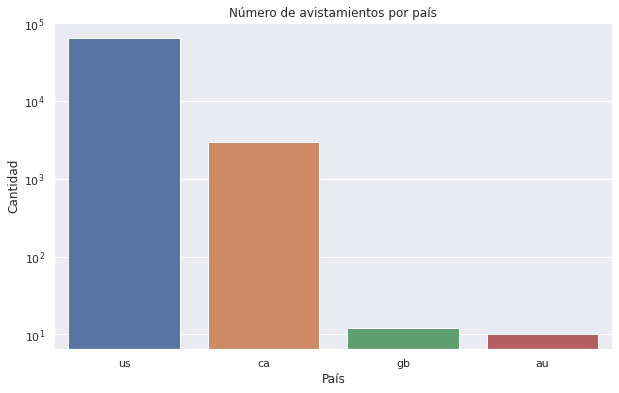

In [22]:
sns.set(style='darkgrid')
plt.figure(figsize=(10,6))
ax = sns.countplot(x='country', 
                   data=df,
                  order = df['country'].value_counts().index, log=True).\
set_title('Número de avistamientos por país')

plt.ylabel('Cantidad')
plt.xlabel('País')
plt.show()

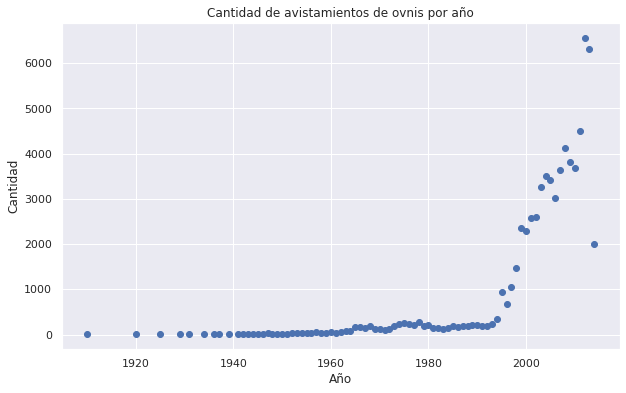

In [23]:
año = pd.DataFrame(df['year'].value_counts()).reset_index()
plt.figure(figsize=(10,6))
plt.scatter(x=año['index'], y=año['year'])
plt.title('Cantidad de avistamientos de ovnis por año')
plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.show()

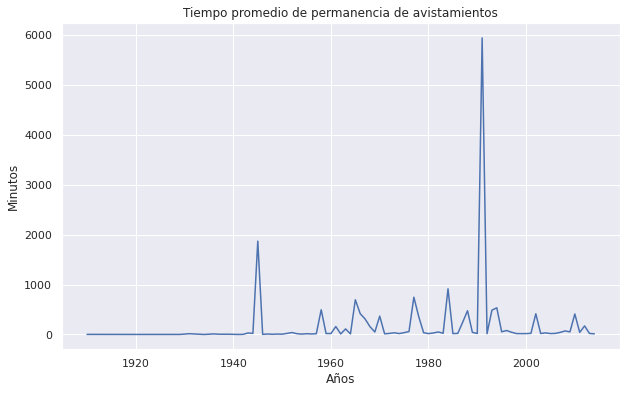

In [24]:
tiempo = df[['year','duration (seconds)']]
tiemposeg = pd.DataFrame(tiempo.groupby('year')['duration (seconds)'].mean())
tiempomin = tiemposeg['duration (seconds)']/60
plt.figure(figsize=(10,6))
plt.plot(tiempomin)
plt.ylabel('Minutos')
plt.xlabel('Años')
plt.title('Tiempo promedio de permanencia de avistamientos')
plt.show()

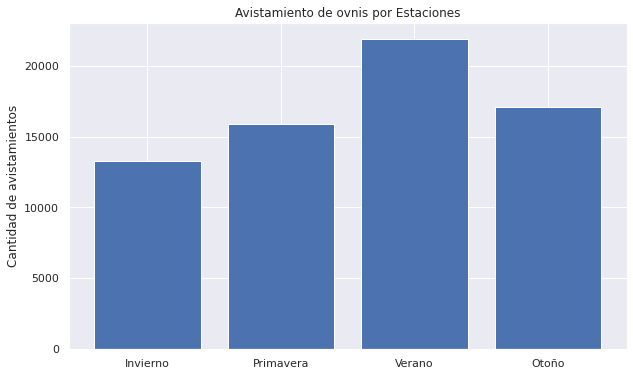

In [25]:
meses=[0]*12
estaciones={'Invierno':0,'Primavera':0,'Verano':0,'Otoño':0}
horac=[0]*24
tiempodia={'Noche': 0,'Amanecer': 0,'Día': 0,'Anochecer':0}
for i in df['datetime']:
    mes=i.month
    meses[mes-1]+=1 
    if mes in (1,2,3):
        estaciones['Invierno']+=1
    elif mes in (4,5,6):
        estaciones['Primavera']+=1
    elif mes in (7,8,9):
        estaciones['Verano']+=1
    elif mes in (10,11,12):
        estaciones['Otoño']+=1
        
    hora = i.hour
    horac[hora]+=1
    if hora in (21,22,23,0,1,2):
        tiempodia['Noche']+=1
    elif hora in range(3,9):
        tiempodia['Amanecer']+=1
    elif hora in range(9,15):
        tiempodia['Día']+=1
    elif hora in range(15,21):
        tiempodia['Anochecer']+=1

plt.figure(figsize=(10,6))
plt.bar(estaciones.keys(), estaciones.values())
plt.title('Avistamiento de ovnis por Estaciones')
plt.ylabel('Cantidad de avistamientos')
plt.show()

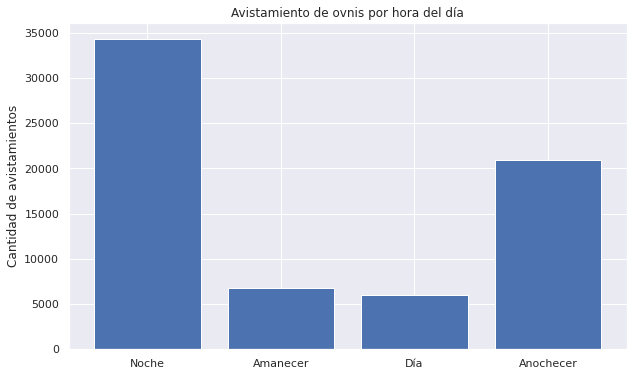

In [26]:
plt.figure(figsize=(10,6))
plt.bar(tiempodia.keys(), tiempodia.values())
plt.title('Avistamiento de ovnis por hora del día')
plt.ylabel('Cantidad de avistamientos')
plt.show()

## EDA USA

In [27]:
numavis = pd.DataFrame(df.groupby('state')['state'].count())
numavis['Número'] = numavis['state']
x = pd.Series(numavis.index).apply(lambda x: x.upper())
numavis.index = np.arange(0, numavis.shape[0])
numavis['Estado'] = x
numavis.drop('state', axis=1, inplace=True)
numavis

,Número,Estado
0,288,AB
1,319,AK
2,643,AL
3,588,AR
4,2414,AZ
...,...,...
62,1232,WI
63,449,WV
64,175,WY
65,2,YK


In [28]:
data=dict(type='choropleth',
          colorscale='Tealgrn',
          z=numavis['Número'],
          locations=numavis['Estado'],
          locationmode= 'USA-states',
          text=numavis['Estado'],
          marker=dict(line=dict(color='rgb(255,255,255)',width=1)),
          colorbar={'title': 'Número de avistamientos de Ovnis'})


In [29]:
layout=dict(title=' Avistamientos de Ovnis en USA',
            geo=dict(scope='usa',
                     showlakes= True,
                     lakecolor='rgb(85,173,240)')
            )

In [30]:
choromap=go.Figure(data=[data],layout=layout)

In [31]:
choromap.show()

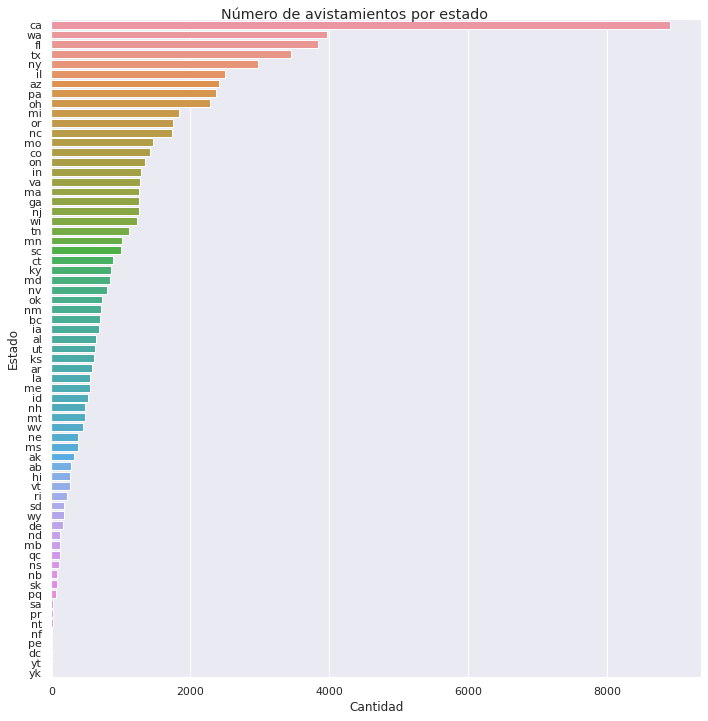

In [32]:
ax = sns.catplot(y='state',
            data=df,
            kind='count',
            height=10,
            order = df['state'].value_counts().index)

ax.fig.suptitle('Número de avistamientos por estado', x=0.5, y=1)

plt.ylabel('Estado')
plt.xlabel('Cantidad')
plt.show()

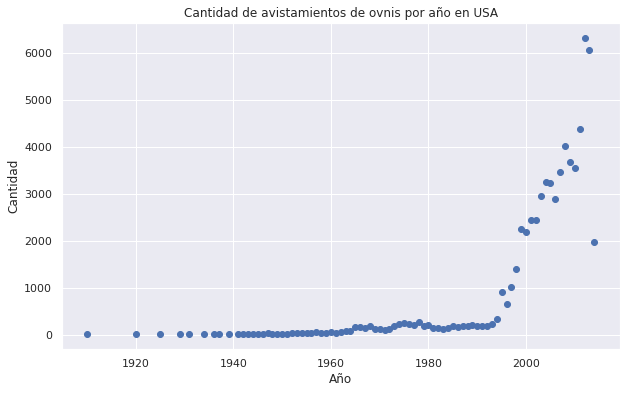

In [33]:
usa =df.loc[(df['country'] == 'us')]#Datos solo de USA

año = pd.DataFrame(usa['year'].value_counts()).reset_index()
plt.figure(figsize=(10,6))
plt.scatter(x=año['index'], y=año['year'])
plt.title('Cantidad de avistamientos de ovnis por año en USA')
plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.show()

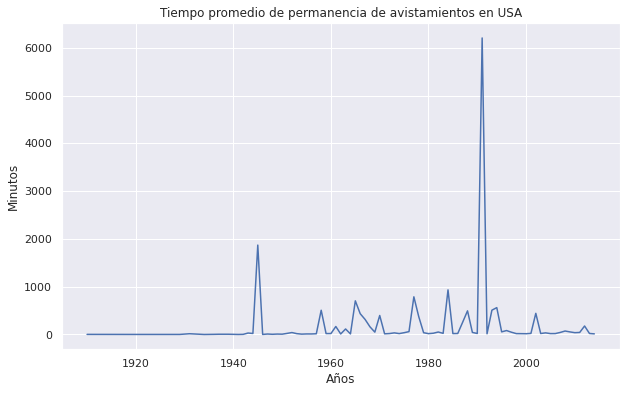

In [34]:
tiempo = usa[['year','duration (seconds)']]
tiemposeg = pd.DataFrame(tiempo.groupby('year')['duration (seconds)'].mean())
tiempomin = tiemposeg['duration (seconds)']/60
plt.figure(figsize=(10,6))
plt.plot(tiempomin)
plt.ylabel('Minutos')
plt.xlabel('Años')
plt.title('Tiempo promedio de permanencia de avistamientos en USA')
plt.show()

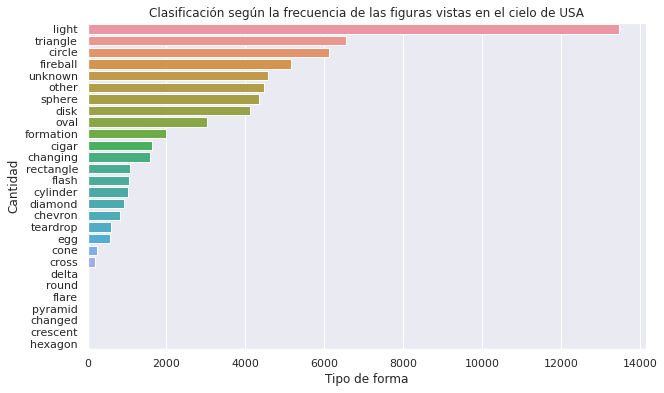

In [35]:
plt.figure(figsize=(10,6))
ax = sns.countplot(y='shape', 
                   data=usa,
                   order = usa['shape'].value_counts().index).\
set_title('Clasificación según la frecuencia de las figuras vistas en el cielo de USA')

plt.ylabel('Cantidad')
plt.xlabel('Tipo de forma')
plt.show()

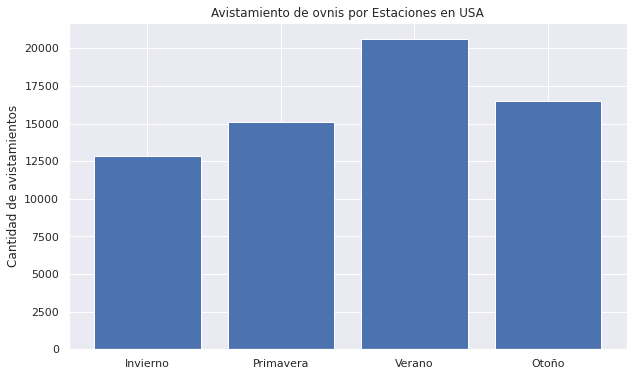

In [36]:
meses=[0]*12
estaciones={'Invierno':0,'Primavera':0,'Verano':0,'Otoño':0}
horac=[0]*24
tiempodia={'Noche': 0,'Amanecer': 0,'Día': 0,'Anochecer':0}
for i in usa['datetime']:
    mes=i.month
    meses[mes-1]+=1 
    if mes in (1,2,3):
        estaciones['Invierno']+=1
    elif mes in (4,5,6):
        estaciones['Primavera']+=1
    elif mes in (7,8,9):
        estaciones['Verano']+=1
    elif mes in (10,11,12):
        estaciones['Otoño']+=1
        
    hora = i.hour
    horac[hora]+=1
    if hora in (21,22,23,0,1,2):
        tiempodia['Noche']+=1
    elif hora in range(3,9):
        tiempodia['Amanecer']+=1
    elif hora in range(9,15):
        tiempodia['Día']+=1
    elif hora in range(15,21):
        tiempodia['Anochecer']+=1

plt.figure(figsize=(10,6))
plt.bar(estaciones.keys(), estaciones.values())
plt.title('Avistamiento de ovnis por Estaciones en USA')
plt.ylabel('Cantidad de avistamientos')
plt.show()

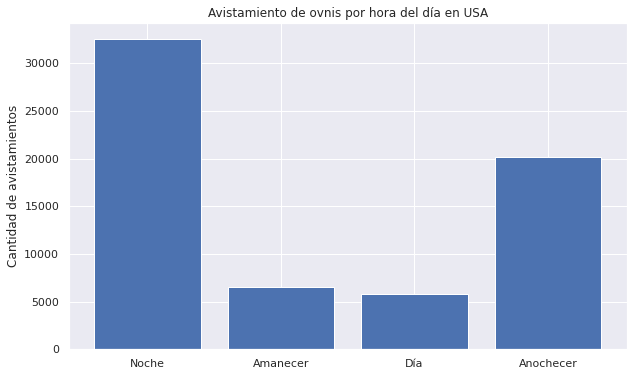

In [37]:
plt.figure(figsize=(10,6))
plt.bar(tiempodia.keys(), tiempodia.values())
plt.title('Avistamiento de ovnis por hora del día en USA')
plt.ylabel('Cantidad de avistamientos')
plt.show()

## EDA California

In [38]:
usa =df.loc[(df['country'] == 'us')]#Datos solo de USA
cal=usa.loc[(df['state'] == 'ca')]#Datos solo de California
cal

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,geometry,year
10,1968-10-10 13:00:00,hawthorne,ca,us,circle,300.0,5 min.,ROUND &#44 ORANGE &#44 WITH WHAT I WOULD SAY W...,10/31/2003,33.916389,-118.351667,POINT (-118.35167 33.91639),1968
30,1979-10-10 22:00:00,san diego,ca,us,oval,180.0,3 minutes,My 2nd UFO sighting&#44 October 1979,8/5/2001,32.715278,-117.156389,POINT (-117.15639 32.71528),1979
45,1989-10-10 00:00:00,calabasas,ca,us,disk,300.0,approx 5 min,Unidentified object on Mulholland Highway.,12/14/2004,34.157778,-118.637500,POINT (-118.63750 34.15778),1989
63,1995-10-10 22:40:00,oakland,ca,us,NaN,60.0,1 minute,Woman repts. bright light in NW sky&#44 sudde...,11/2/1999,37.804444,-122.269722,POINT (-122.26972 37.80444),1995
72,1998-10-10 02:30:00,hollywood,ca,us,changing,300.0,5 minutes,I was standing outside on Sunset Blvd. at Vine...,11/1/1998,34.098333,-118.325833,POINT (-118.32583 34.09833),1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80299,2012-09-09 20:00:00,arcata,ca,us,formation,600.0,10 minutes,Object with red and green lights moving sited ...,9/24/2012,40.866667,-124.081667,POINT (-124.08167 40.86667),2012
80305,2012-09-09 20:30:00,ventura,ca,us,chevron,900.0,15 minutes,Beautiful bright blue delta shaped aerobatics.,9/24/2012,34.278333,-119.292222,POINT (-119.29222 34.27833),2012
80310,2012-09-09 21:00:00,ventura,ca,us,circle,300.0,5 minutes,Bright Blue Object seen floating in sky near C...,9/24/2012,34.278333,-119.292222,POINT (-119.29222 34.27833),2012
80316,2013-09-09 09:51:00,san diego,ca,us,light,4.0,~4 seconds,2 white lights zig-zag over Qualcomm Stadium (...,9/30/2013,32.715278,-117.156389,POINT (-117.15639 32.71528),2013


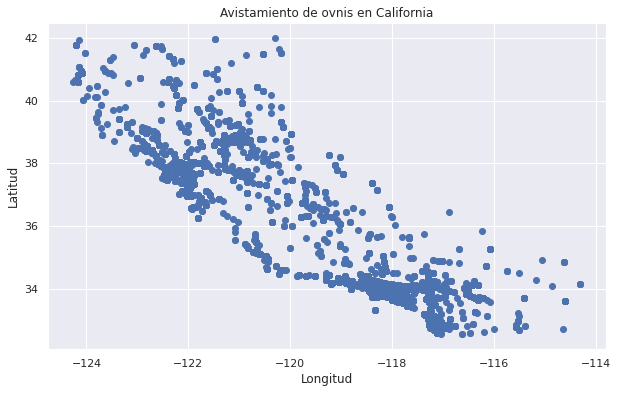

In [39]:
plt.figure(figsize=(10,6))
plt.scatter(x=cal['longitude '], y=cal['latitude'])
plt.title('Avistamiento de ovnis en California')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

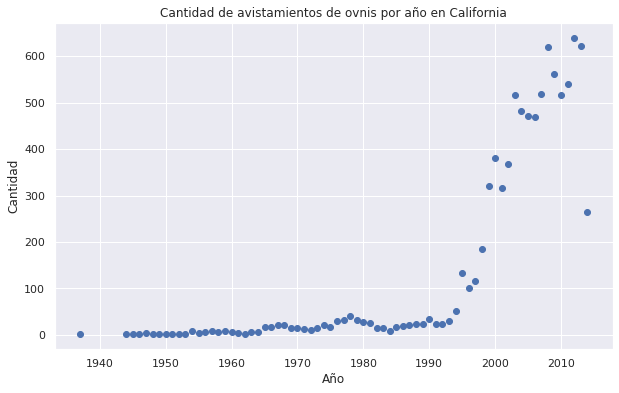

In [40]:
año = pd.DataFrame(cal['year'].value_counts()).reset_index()
plt.figure(figsize=(10,6))
plt.scatter(x=año['index'], y=año['year'])
plt.title('Cantidad de avistamientos de ovnis por año en California')
plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.show()

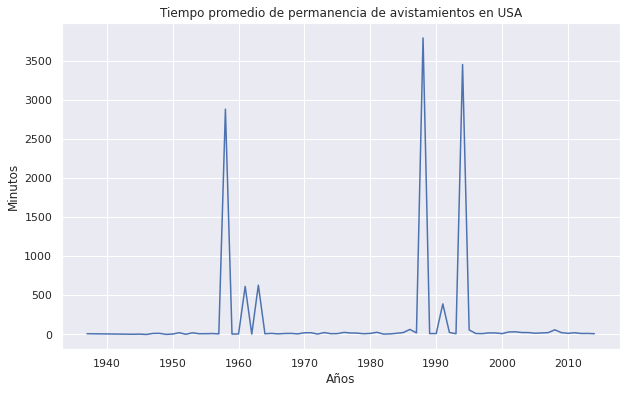

In [41]:
tiempo = cal[['year','duration (seconds)']]
tiemposeg = pd.DataFrame(tiempo.groupby('year')['duration (seconds)'].mean())
tiempomin = tiemposeg['duration (seconds)']/60
plt.figure(figsize=(10,6))
plt.plot(tiempomin)
plt.ylabel('Minutos')
plt.xlabel('Años')
plt.title('Tiempo promedio de permanencia de avistamientos en USA')
plt.show()

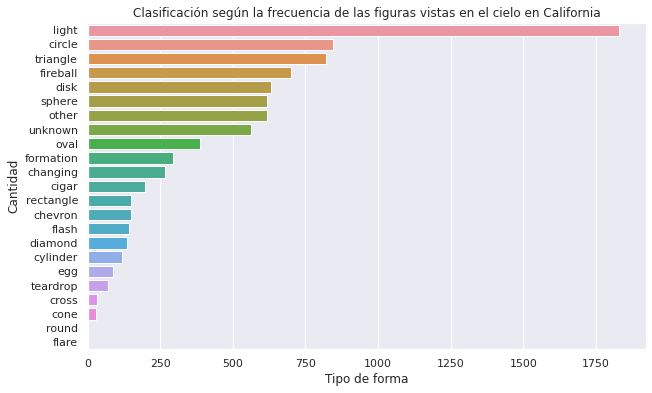

In [42]:
plt.figure(figsize=(10,6))
ax = sns.countplot(y='shape', 
                   data=cal,
                   order = cal['shape'].value_counts().index).\
set_title('Clasificación según la frecuencia de las figuras vistas en el cielo en California')

plt.ylabel('Cantidad')
plt.xlabel('Tipo de forma')
plt.show()

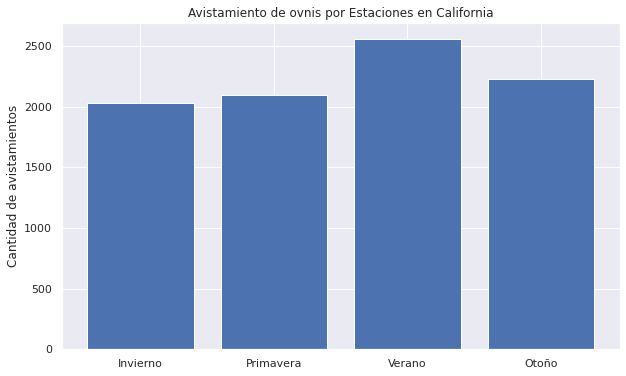

In [43]:
meses=[0]*12
estaciones={'Invierno':0,'Primavera':0,'Verano':0,'Otoño':0}
horac=[0]*24
tiempodia={'Noche': 0,'Amanecer': 0,'Día': 0,'Anochecer':0}
for i in cal['datetime']:
    mes=i.month
    meses[mes-1]+=1 
    if mes in (1,2,3):
        estaciones['Invierno']+=1
    elif mes in (4,5,6):
        estaciones['Primavera']+=1
    elif mes in (7,8,9):
        estaciones['Verano']+=1
    elif mes in (10,11,12):
        estaciones['Otoño']+=1
        
    hora = i.hour
    horac[hora]+=1
    if hora in (21,22,23,0,1,2):
        tiempodia['Noche']+=1
    elif hora in range(3,9):
        tiempodia['Amanecer']+=1
    elif hora in range(9,15):
        tiempodia['Día']+=1
    elif hora in range(15,21):
        tiempodia['Anochecer']+=1

plt.figure(figsize=(10,6))
plt.bar(estaciones.keys(), estaciones.values())
plt.title('Avistamiento de ovnis por Estaciones en California')
plt.ylabel('Cantidad de avistamientos')
plt.show()

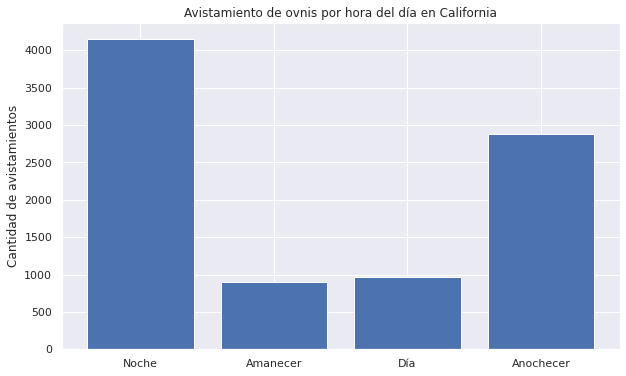

In [44]:
plt.figure(figsize=(10,6))
plt.bar(tiempodia.keys(), tiempodia.values())
plt.title('Avistamiento de ovnis por hora del día en California')
plt.ylabel('Cantidad de avistamientos')
plt.show()